In [3]:
import urllib2
import time
from datetime import datetime
from bs4 import BeautifulSoup
import re, os
import json
from lxml import etree, html
import requests
import pandas as pd
import numpy as np
import cPickle
from pymongo import MongoClient
#from lxml import html

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Some MongoDB Notes
Find all distinct user names:  
```
db.users.distinct("user_info.personaname")
```

# Steam API
## Friends From Friends
```
http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key=XXXX&steamid=XXXX&relationship=all
```

In [32]:
def get_friends(id):
    '''
    Starting with a single user ID, return their friends
    '''
    key = os.environ['ACCESS_STEAM']
    url = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='+key+'&steamid='+id+'&relationship=all'
    return json.loads(urllib2.urlopen(url).read())['friendslist']['friends']

## Basic User Info
```
http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key=XXXX&steamids=XXXX,YYYY
```
* Comma-delimited list of 64 bit Steam IDs to return profile information for. Up to 100 Steam IDs can be requested.

In [30]:
def get_user_info(ids):
    '''
    For a user or users (up to 100 comma-delimited),
    return some basic user information
    '''
    key = os.environ['ACCESS_STEAM']
    url = 'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key='+key+'&steamids='+ids
    return json.loads(urllib2.urlopen(url).read())['response']['players'][0]

## Player Bans
```
http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key=XXXX&steamids=XXXX,YYYY
```


In [13]:
def get_bans(ids):
    '''
    Looks at the IDS ban history
    '''
    key = os.environ['ACCESS_STEAM']
    url = 'http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key='+key+'&steamids='+ids
    return json.loads(urllib2.urlopen(url).read())['players']

In [224]:
test_list = list(public)[:200]

In [99]:
begin = SteamStuff()
begin.mongodb_connection()

In [201]:
begin.user_id("76561198000127691")

In [206]:
begin.scrape_profile()

''

[u'76561197971340950',
 u'76561197988952025',
 u'76561198169761153',
 u'76561198002922051',
 u'76561198109725137',
 u'76561198085049223',
 u'76561198000127691',
 u'76561198094890595',
 u'76561198094033169',
 u'76561197998907707']

In [133]:
begin.get_friends()

[{u'friend_since': 0, u'steamid': u'76561197960559382'},
 {u'friend_since': 0, u'steamid': u'76561197965632101'},
 {u'friend_since': 1439867952, u'steamid': u'76561197982823731'},
 {u'friend_since': 1404070051, u'steamid': u'76561197999882487'},
 {u'friend_since': 1235243760, u'steamid': u'76561198001133491'},
 {u'friend_since': 1323645317, u'steamid': u'76561198040942123'},
 {u'friend_since': 1436489293, u'steamid': u'76561198086767969'}]

In [144]:
begin.user_id("76561197982823731")
try:
    begin.get_friends()
except:
    print "private"

private


In [231]:
begin.user_id(my_id)

In [232]:
begin.get_friends()

[{u'friend_since': 0, u'steamid': u'76561197960559382'},
 {u'friend_since': 0, u'steamid': u'76561197965632101'},
 {u'friend_since': 1439867952, u'steamid': u'76561197982823731'},
 {u'friend_since': 1404070051, u'steamid': u'76561197999882487'},
 {u'friend_since': 1235243760, u'steamid': u'76561198001133491'},
 {u'friend_since': 1323645317, u'steamid': u'76561198040942123'},
 {u'friend_since': 1436489293, u'steamid': u'76561198086767969'}]

In [229]:
begin.s_code

False

In [226]:
begin = SteamStuff()
begin.mongodb_connection()

In [227]:
t0 = time.time()
for uid in test_list:
    begin.user_id(uid)
    if begin.s_code:
        begin.build_dict()
        begin.insert_document()
    else:
        print "We don't even like {}".format(uid)
print "took {0} seconds to collect and insert data for {1}".format((time.time()-t0), len(test_list))

We don't even like 76561198000127691
We don't even like 76561198023956576
We don't even like 76561197993262226
We don't even like 76561197971433883
We don't even like 76561197985709312
We don't even like 76561197963926152
We don't even like 76561198164638152
We don't even like 76561198082344211
We don't even like 76561198055761502
We don't even like 76561198092725189
We don't even like 76561197963328643
We don't even like 76561198009469261
We don't even like 76561197970914857
We don't even like 76561198016945492
We don't even like 76561197972492038
We don't even like 76561197961558433
We don't even like 76561197991874591
We don't even like 76561197969633521
We don't even like 76561197999256936
We don't even like 76561198009477939
We don't even like 76561197972346185
We don't even like 76561197983722049
We don't even like 76561198010349881
We don't even like 76561197982157782
We don't even like 76561197998459878


# API Class Helper

In [207]:
class SteamStuff(object):
    """
    Class to keep track of Steam APIs.
    Ideally will return usful info.
    Pass in the Steam API key to get going!
    """
    
    def __init__(self):
        """
        Initialize with the Steam API key and Game ID (if needed)
        """
        self.key = os.environ["ACCESS_STEAM"]
        self.uid = None
        self.player_dict = {}
        self.db = None
        self.s_code = None
        self.friend_response = None
        
    
    def user_id(self, uid):
        """
        Resets self.uid to a new 17-digit user ID
        Also checks the GetFriendList API for a status code of 200 (public user)
        or 401 (private user)
        """
        self.uid = uid
        url = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='\
               +self.key+'&steamid='+self.uid+'&relationship=all'
        #friends = json.loads(urllib2.urlopen(url).read())['friendslist']['friends']
        response = requests.get(url)
        self.s_code = str(response.status_code).startswith("2")
        self.friend_response = response
    
    
    def mongodb_connection(self):
        """
        Connect to MongoDB 'steam'
        """
        client = MongoClient()
        self.db = client.steam
        
        
    def insert_document(self, collection_name="users"):
        """
        Insert a player dictionary document in db_name of MongoDB
        """
        #name = collection_name
        self.db.users.insert_one(self.player_dict)
        
        
    def get_bans(self):
        """
        INPUTS:
          self - .key: API key
                 .uid: 17-digit Steam ID string, up to 100 comma-delimited
        OUTPUTS:
          Dictionary:
            {u'CommunityBanned': False,
             u'DaysSinceLastBan': 0,
             u'EconomyBan': u'none',
             u'NumberOfGameBans': 0, 
             u'NumberOfVACBans': 0,
             u'SteamId': u'76561197967398882', UPDATE - removed
             u'VACBanned': False} VAC is for online gaming
             
        Looks at the 17-digit ID's ban history (up to 100 comma-delimited IDs)
        """
        url = 'http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key='+self.key+'&steamids='+self.uid
        #ban = json.loads(urllib2.urlopen(url).read())['players'][0]
        response = requests.get(url)
        self.s_code = str(response.status_code).startswith("2")
        ban = response.json()["players"][0]
        desired_keys = set(ban.keys()) - set(["SteamId"])
        return {k: ban[k] for k in desired_keys}
    
    
    def get_user_info(self):
        """
        INPUTS:
          self - .key: API key
                 .uid: 17-digit Steam ID string, up to 100 comma-delimited 
        OUTPUTS:
          Dictionary:
          {u'avatar': u'https://steamcdn-a.akamaihd.net/.../jpg', # REMOVED
           u'avatarfull': u'https://steamcdn-a.akamaihd.net/.../full.jpg',
           u'avatarmedium': u'https://steamcdn-a.akamaihd.net/.../medium.jpg', # REMOVED
           u'communityvisibilitystate': 3,   # 1 - private profile, 3 - public profile
           u'lastlogoff': 1460189153,  # epoch time
           u'loccountrycode': u'VA',    # May need to look into how to pull that out. Some also have "locstatecode"
           u'personaname': u'Deck Gumby',
           u'personastate': 0,      # 0 - Offline, 1 - Online, 2 - Busy, 3 - Away, 4 - Snooze, 5 - looking to trade, 6 - looking to play.
           u'personastateflags': 0, #
           u'primaryclanid': u'103582791432291036',
           u'profilestate': 1,      # If set, indicates the user has a community profile configured (will be set to '1')
           u'profileurl': u'http://steamcommunity.com/id/deckgumby/',
           u'realname': u'Ken Tucky',
           u'steamid': u'76561197967398882',
           u'timecreated': 1089486992}    # epoch time
        For a user or users (up to 100 comma-delimited),
        return some basic user information
        """
        url = 'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key='\
               +self.key+'&steamids='+self.uid
        #user = json.loads(urllib2.urlopen(url).read())['response']['players'][0]
        user = requests.get(url).json()["response"]["players"][0]
        desired_keys = set(user.keys()) - set(["steamid", "profileurl", "personastateflags", "avatar", "avatarmedium", "steamid"])
        return {k: user[k] for k in desired_keys}
    
    
    def get_friends(self):
        """
        INPUTS:
          self - .key: API key
                 .uid: 17-digit Steam ID
        OUTPUT:
          List of dictionaries, e.g.,
            {u'friend_since': 0,
             u'relationship': u'friend', UPDATE - now removes this field
             u'steamid': u'76561197960559382'}
        Starting with a single user ID, return their friends
        If public, only return users who have public profiles
        """
        #url = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='\
        #       +self.key+'&steamid='+self.uid+'&relationship=all'
        #friends = json.loads(urllib2.urlopen(url).read())['friendslist']['friends']
        #response = requests.get(url)
        #self.s_code = str(response.status_code).startswith("2")
        friends = self.friend_response.json()["friendslist"]["friends"]
        excluding = set(["relationship"])
        return [{k: friend[k] for k in (set(friend.keys()) - excluding)} for friend in friends]
    
    
    def get_game_info(self):
        """
        INPUTS:
          self - .key: API key
                 .uid: 17-digit Steam ID
        OUTPUT:
          List of dictionaries, e.g.,
            {u'appid': 10,
             u'has_community_visible_stats': True,
             u'img_icon_url': u'6b0312cda02f5f777efa2f3318c307ff9acafbb5', UPDATE - removed
             u'img_logo_url': u'af890f848dd606ac2fd4415de3c3f5e7a66fcb9f', UPDATE - removed
             u'name': u'Counter-Strike',
             u'playtime_forever': 0, in minutes
             u'playtime_2weeks': 0} in minutes UPDATE - added whether played in two weeks or not
             
        Get owned game information for a give user
        Returns a list of dictionaries
        """
        url =  "http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key="\
                +self.key+"&steamid="+self.uid+"&include_appinfo=1\
                &include_played_free_games=1&format=json"
        #games = json.loads(urllib2.urlopen(url).read())["response"]["games"]
        games = requests.get(url).json()["response"]["games"]
        for i, game in enumerate(games):
            desired_keys = set(game.keys()) - set(["has_community_visible_stats", "img_icon_url", "img_logo_url"])
            if "playtime_2weeks" in desired_keys:
                game = {k: game[k] for k in desired_keys}
                games[i] = game
            else:
                game = {k: game[k] for k in desired_keys}
                game[u"playtime_2weeks"] = 0
                games[i] = game
        return games
    
    
    def get_player_achievments(self, appid):
        """
        Given a player ID and appid, return a list of achievments
        """
        url = "http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?appid="+appid+"&key="+self.key+"&steamid="+self.uid
        playerstats = json.loads(urllib2.urlopen(url).read())["playerstats"]
        return {k: playerstats[k] for k in ("achievements", "gameName")}
    
    
    def scrape_profile(self):
        """
        Look at a user's community profile
        Maybe include '?xml=1' at the end of the url?
        """
        url = "http://steamcommunity.com/profiles/"+self.uid
        text = requests.get(url).text
        rm_delims = re.sub(r"[\t\r\n]+", r" ", text)
        rm_breaks = re.sub(r"\<br\>+", r" ", rm_delims).strip()
        soup = BeautifulSoup(rm_breaks, "lxml")
        ### profile summary statement
        profile_summary = " ".join(re.findall(r"[0-9a-zA-Z\.\,\!\?\'\"\$]+", " ".join(\
                                              [list(link.stripped_strings) for link in soup.find_all(\
                                              "div", "profile_header_summary")][0][:-2])))
        
        
        profile_items = soup.find_all("div", "profile_count_link")
        profile_items = [{list(link.stripped_strings)[0]:list(link.stripped_strings)[-1]} for link in profile_items]
        profile_items = dict(i.items()[0] for i in profile_dict)
        
        
        
        return profile_summary, profile_items
        
        
        
        #pass
    
    
    def game_info(self, appid):
        """
        Get the information for a given game / appid
        """
        url = ""
        pass
        
        
    def get_global_achievements(self, appid):
        """
        Get the global achievement stats, kinda intersting
        Currently returns a LIST of achievement name / global completion percentages; maybe average one number?
        """
        url = "http://api.steampowered.com/ISteamUserStats/GetGlobalAchievementPercentagesForApp/v0002/?gameid="+appid+"&format=json"
        return json.loads(urllib2.urlopen(url).read())["achievementpercentages"]["achievements"]
    
    
    def build_dict(self):
        """
        Reference above functions to build a player info dictionary
        Eventually do a self.id kinda thang, naw mean?
        """
        
        self.player_dict = None
        self.player_dict = {}
        self.player_dict["ban_status"] = self.get_bans()
        self.player_dict["friends"] = self.get_friends()
        self.player_dict["game_info"] = self.get_game_info()
        self.player_dict["user_info"] = self.get_user_info()
        self.player_dict["profile_summary"] = self.scrape_profile()
        self.player_dict["steamid"] = self.uid
        #self.player_dict["achievments"] = self.get_player_achievments() needs a specific game
    
    
    def check_out(self):
        """
        Returns a built-up dictionary
        """
        return self.player_dict

In [233]:
url = url = "http://steamcommunity.com/profiles/"+os.environ["STEAM_ID"]
url

'http://steamcommunity.com/profiles/76561198050495772'

In [254]:
url = "http://steamcommunity.com/profiles/"+os.environ["STEAM_ID"]
text = requests.get(url).text
rm_delims = re.sub(r"[\t\r\n]+", r" ", text)
rm_breaks = re.sub(r"\<br\>+", r" ", rm_delims).strip()
soup = BeautifulSoup(rm_breaks, "lxml")

In [264]:
profile_links = soup.find_all("div", "gamecollector_showcase")
[{list(link.stripped_strings)[0]:list(link.stripped_strings)[-1]} for link in profile_links]

[{u'448': u'Featured Games'}]

In [265]:
soup = BeautifulSoup(requests.get(url).content, "lxml")
#location_html = stadium_soup.select_one("span.geo-dec")

In [267]:
soup.select_one("div.gamecollector_showcase").text

u'\n\n\n448\nGames Owned\n\n\n185\nDLC Owned\n\n\n16\nReviews\n\n\n203\nWishlisted\n\n\n\n\r\n\t\t\t\t\tFeatured Games\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [255]:

#profile_dict = {}
profile_links = soup.find_all("div", "profile_count_link")
profile_dict = [{list(link.stripped_strings)[0]:list(link.stripped_strings)[-1]} for link in profile_links]
dict(i.items()[0] for i in profile_dict)

{u'Artwork': u'5',
 u'Badges': u'41',
 u'Friends': u'159',
 u'Games': u'448',
 u'Groups': u'17',
 u'Guides': u'4',
 u'Inventory': u'Inventory',
 u'Reviews': u'16',
 u'Screenshots': u'99',
 u'Videos': u'6'}

In [268]:
requests.get(url).text == requests.get(url).content

/Users/johnnysand/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if __name__ == '__main__':


False

In [199]:
users.get_friends()

[{u'friend_since': 0, u'steamid': u'76561197960559382'},
 {u'friend_since': 0, u'steamid': u'76561197965632101'},
 {u'friend_since': 1439867952, u'steamid': u'76561197982823731'},
 {u'friend_since': 1404070051, u'steamid': u'76561197999882487'},
 {u'friend_since': 1235243760, u'steamid': u'76561198001133491'},
 {u'friend_since': 1323645317, u'steamid': u'76561198040942123'},
 {u'friend_since': 1436489293, u'steamid': u'76561198086767969'}]

In [275]:
final_dict = {}
final_dict.update({"a":2, "b":3})
final_dict.update({"d":5})
final_dict

{'a': 2, 'b': 3, 'd': 5}

brian = SteamStuff()

In [272]:
brian.user_id("76561197999882487")

In [273]:
brian.get_user_info()

{u'avatarfull': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/be/be2e1575d5ca6a6cbdc7b96f01f617297e177741_full.jpg',
 u'communityvisibilitystate': 3,
 u'gameextrainfo': u'Battleborn Open Beta',
 u'gameid': u'451070',
 u'lastlogoff': 1460407579,
 u'personaname': u'BriBri',
 u'personastate': 1,
 u'primaryclanid': u'103582791439817145',
 u'profilestate': 1,
 u'realname': u'Brian McAdams',
 u'timecreated': 1216015854}

In [192]:
users.build_dict()

In [193]:
users.player_dict

{'ban_status': {u'CommunityBanned': False,
  u'DaysSinceLastBan': 0,
  u'EconomyBan': u'none',
  u'NumberOfGameBans': 0,
  u'NumberOfVACBans': 0,
  u'VACBanned': False},
 'friends': [{u'friend_since': 0, u'steamid': u'76561197960559382'},
  {u'friend_since': 0, u'steamid': u'76561197965632101'},
  {u'friend_since': 1439867952, u'steamid': u'76561197982823731'},
  {u'friend_since': 1404070051, u'steamid': u'76561197999882487'},
  {u'friend_since': 1235243760, u'steamid': u'76561198001133491'},
  {u'friend_since': 1323645317, u'steamid': u'76561198040942123'},
  {u'friend_since': 1436489293, u'steamid': u'76561198086767969'}],
 'game_info': [{u'appid': 10,
   u'name': u'Counter-Strike',
   u'playtime_2weeks': 0,
   u'playtime_forever': 0},
  {u'appid': 20,
   u'name': u'Team Fortress Classic',
   u'playtime_2weeks': 0,
   u'playtime_forever': 0},
  {u'appid': 30,
   u'name': u'Day of Defeat',
   u'playtime_2weeks': 0,
   u'playtime_forever': 0},
  {u'appid': 40,
   u'name': u'Deathmatch 

In [173]:
url = 'http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key='+os.environ["ACCESS_STEAM"]+'&steamids='+my_id
  
url

'http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key=9BD62BA0CD75599091D3C1257782D97D&steamids=76561197967398882'

### Replacing urllib with requests.get() -- seems a little simpler
Before: &nbsp;`user = json.loads(urllib2.urlopen(url).read())['response']['players'][0]`   
After: &nbsp;&nbsp;&nbsp;&nbsp;`user = requests.get(url).json()["response"]["players"][0]`    

`friends = json.loads(urllib2.urlopen(url).read())['friendslist']['friends']`  
`games = json.loads(urllib2.urlopen(url).read())["response"]["games"]`  
`ban = json.loads(urllib2.urlopen(url).read())['players'][0]`

In [178]:
response = requests.get(url)
response.status_code

200

In [177]:
response.json()["players"][0]

{u'CommunityBanned': False,
 u'DaysSinceLastBan': 0,
 u'EconomyBan': u'none',
 u'NumberOfGameBans': 0,
 u'NumberOfVACBans': 0,
 u'SteamId': u'76561197967398882',
 u'VACBanned': False}

In [160]:
str(response.status_code).startswith("2")

False

In [131]:
begin.user_id(my_id)
begin.get_game_info()

[{u'appid': 10,
  u'name': u'Counter-Strike',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 20,
  u'name': u'Team Fortress Classic',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 30,
  u'name': u'Day of Defeat',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 40,
  u'name': u'Deathmatch Classic',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 50,
  u'name': u'Half-Life: Opposing Force',
  u'playtime_2weeks': 0,
  u'playtime_forever': 248},
 {u'appid': 60,
  u'name': u'Ricochet',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 70,
  u'name': u'Half-Life',
  u'playtime_2weeks': 0,
  u'playtime_forever': 2},
 {u'appid': 130,
  u'name': u'Half-Life: Blue Shift',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 80,
  u'name': u'Counter-Strike: Condition Zero',
  u'playtime_2weeks': 0,
  u'playtime_forever': 0},
 {u'appid': 100,
  u'name': u'Counter-Strike: Condition Zero Deleted Scenes',
  u'

In [46]:
user_info = SteamStuff()
#my_id = os.environ["MY_STEAM"]

In [48]:
user_info.mongodb_connection()

In [47]:
user_info.user_id(os.environ["MY_STEAM"])

In [49]:
user_info.build_dict()

In [50]:
user_info.insert_document()

In [32]:
user_info.player_dict

{'_id': ObjectId('570e649163210f01baa27d38'),
 'ban_status': {u'CommunityBanned': False,
  u'DaysSinceLastBan': 0,
  u'EconomyBan': u'none',
  u'NumberOfGameBans': 0,
  u'NumberOfVACBans': 0,
  u'VACBanned': False},
 'friends': [{u'friend_since': 0, u'steamid': u'76561197960559382'},
  {u'friend_since': 0, u'steamid': u'76561197965632101'},
  {u'friend_since': 1439867952, u'steamid': u'76561197982823731'},
  {u'friend_since': 1404070051, u'steamid': u'76561197999882487'},
  {u'friend_since': 1235243760, u'steamid': u'76561198001133491'},
  {u'friend_since': 1323645317, u'steamid': u'76561198040942123'},
  {u'friend_since': 1436489293, u'steamid': u'76561198086767969'}],
 'game_info': [{u'appid': 10,
   u'name': u'Counter-Strike',
   u'playtime_2weeks': 0,
   u'playtime_forever': 0},
  {u'appid': 20,
   u'name': u'Team Fortress Classic',
   u'playtime_2weeks': 0,
   u'playtime_forever': 0},
  {u'appid': 30,
   u'name': u'Day of Defeat',
   u'playtime_2weeks': 0,
   u'playtime_forever': 

In [648]:
user_info.build_dict()

In [637]:
user_info.build_dict()

```python
user_stuff = list()
get_stuff = SteamStuff()
for user in list10:
    print user
    get_stuff.user_id(user)
    get_stuff.build_dict()
    user_stuff.append(get_stuff.player_dict)
    # Failed due to PRIVATE user
```

In [ ]:
user_stuff

In [167]:
my_games = user_info.get_game_info(os.environ["STEAM_ID"])

In [ ]:
game_traits = ("appid", "name", "playtime_forever", "playtime_2weeks")

### Looking at indexing with lists versus sets in the `get_bans` function

In [156]:
t_time_list = []
for t in xrange(100):
    t0 = time.time()
    bans = user_info.get_bans(os.environ["STEAM_ID"])
    t_time_list.append(time.time() - t0)
print sum(t_time_list) / float(len(t_time))

0.152573342323


In [152]:
t_time_set = []
for t in xrange(100):
    t0 = time.time()
    bans = user_info.get_bans(os.environ["STEAM_ID"])
    t_time_set.append(time.time() - t0)
print sum(t_time_set) / float(len(t_time))

0.152361869812


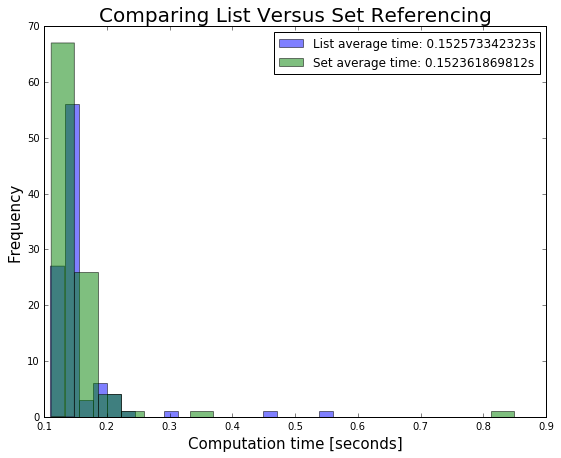

In [163]:
plt.figure(figsize=(9,7))
plt.hist(t_time_list, bins=20, alpha=0.5, label="List average time: {}s".format(sum(t_time_list) / float(len(t_time_list))))
plt.hist(t_time_set, bins=20, alpha=0.5, label="Set average time: {}s".format(sum(t_time_set) / float(len(t_time_set))))
plt.legend()
plt.xlabel("Computation time [seconds]", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Comparing List Versus Set Referencing", fontsize=20)
plt.show()

In [111]:
my_ban = user_info.get_bans(my_id)[0]
my_ban

{u'CommunityBanned': False,
 u'DaysSinceLastBan': 0,
 u'EconomyBan': u'none',
 u'NumberOfGameBans': 0,
 u'NumberOfVACBans': 0,
 u'SteamId': u'76561197967398882',
 u'VACBanned': False}

In [123]:
my_ban.keys()

[u'SteamId',
 u'NumberOfGameBans',
 u'NumberOfVACBans',
 u'DaysSinceLastBan',
 u'EconomyBan',
 u'VACBanned',
 u'CommunityBanned']

In [124]:
{k: my_ban[k] for k in my_ban.keys() if k != "SteamId"}

{u'CommunityBanned': False,
 u'DaysSinceLastBan': 0,
 u'EconomyBan': u'none',
 u'NumberOfGameBans': 0,
 u'NumberOfVACBans': 0,
 u'VACBanned': False}

In [62]:
my_friends

[{'friend_since': 0, 'steamid': u'76561197960559382'},
 {'friend_since': 0, 'steamid': u'76561197965632101'},
 {'friend_since': 1439867952, 'steamid': u'76561197982823731'},
 {'friend_since': 1404070051, 'steamid': u'76561197999882487'},
 {'friend_since': 1235243760, 'steamid': u'76561198001133491'},
 {'friend_since': 1323645317, 'steamid': u'76561198040942123'},
 {'friend_since': 1436489293, 'steamid': u'76561198086767969'}]

In [95]:
user_info.build_dict("76561197960559382")

In [32]:
user_things = ("avatarmedium", "communityvisibilitystate", "lastlogoff", "loccountrycode", "locstatecode", )

1063508781

In [33]:
me = user_info.get_user_info(my_id)["timecreated"]

In [242]:
minuser = user_info.get_user_info("76561198055995417")

In [271]:
mytime = user_info.get_game_info("76561198080951917")

In [272]:
timesum = 0
for game in mytime:
    timesum += game["playtime_forever"]

In [260]:
me = user_info.get_user_info(my_id)

In [277]:
time.gmtime(1385160424)

time.struct_time(tm_year=2013, tm_mon=11, tm_mday=22, tm_hour=22, tm_min=47, tm_sec=4, tm_wday=4, tm_yday=326, tm_isdst=0)

In [266]:
maxuser

[u'steamid',
 u'primaryclanid',
 u'realname',
 u'personaname',
 u'personastate',
 u'personastateflags',
 u'communityvisibilitystate',
 u'loccountrycode',
 u'profilestate',
 u'profileurl',
 u'loccityid',
 u'timecreated',
 u'avatar',
 u'locstatecode',
 u'commentpermission',
 u'avatarfull',
 u'avatarmedium',
 u'lastlogoff']

In [268]:
"timecreated" 

True

In [270]:
user_info.get_user_info("76561197982503327")

{u'avatar': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/00/00a40297103baaf965c72cff9505517e82d1e6e6.jpg',
 u'avatarfull': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/00/00a40297103baaf965c72cff9505517e82d1e6e6_full.jpg',
 u'avatarmedium': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/00/00a40297103baaf965c72cff9505517e82d1e6e6_medium.jpg',
 u'communityvisibilitystate': 3,
 u'lastlogoff': 1460403784,
 u'personaname': u'Saqphire',
 u'personastate': 0,
 u'personastateflags': 0,
 u'primaryclanid': u'103582791435567598',
 u'profilestate': 1,
 u'profileurl': u'http://steamcommunity.com/id/stoppy250/',
 u'steamid': u'76561197982503327',
 u'timecreated': 1147247124}

In [357]:
user_info.scrape_profile(os.environ["STEAM_ID"])

u'Problem officer? I will ignore private profiles. Do NOT add me without a comment. H a l f L i f e 3 My SteamRep steamrep.com My Trade Link .......... ......... ........ ....... ...... ..... .... ... .. . A man saw a lady with big breasts. He asked, "Excuse me, can I bite your breasts for $1000?" She agrees, so they go to a secluded corner. She opens her blouse and the man puts his face in her breasts for 10 minutes." Eventually the lady asks, "Aren\'t you gonna bite them?" He replies, "No, it\'s too expensive." c 3 hi stalker L'

In [4]:
my_id = "76561197967398882"
csid = "730"

In [355]:
user_info.scrape_profile("76561198061166639")

''

## Game Schema; not sure if worth looking into

In [166]:
url = "http://api.steampowered.com/ISteamUserStats/GetSchemaForGame/v2/?key="+os.environ["ACCESS_STEAM"]+"&appid=730"

In [176]:
gamestuff = json.loads(urllib2.urlopen(url).read())

In [180]:
gamestuff["game"].keys()

[u'gameVersion', u'availableGameStats', u'gameName']

# Get an ID Set

In [1]:
class GenerateSteamIds(object):
    """
    Get IDS starting from a single friend or set/list of friends
    """
    def __init__(self):
        self.key = os.environ["ACCESS_STEAM"]
        self.uid = None
        #if type(ids) == str:
        #    self.friends = set([ids])
        #else:
        #    self.friends = ids
        self.public = set()
        self.private = set()
        #self.ids = ids
    
    def generate_steam_ids(self):
        """
        INPUTS:
          ids - single 17-digit Steam ID or list or set of ID strings
        OUTPUTS:
          set - set of PUBLIC 17-digt Steam IDs, at least as many as min_friends
        Generate a bunch of Steam IDs from their friends
        """
        t0 = time.time()
        #key = os.environ["ACCESS_STEAM"]
        friend_set = set()
        #private_users = set()
        #if type(ids) == str:
            #ids = set([ids])# just make sure it's a set if a single ID string is passed in
        
        for uid in self.public:
            url = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='+self.key+'&steamid='+uid+'&relationship=all'
            response = requests.get(url)
            if str(response.status_code).startswith("2"):
                friends = requests.get(url).json()["friendslist"]["friends"]
                for friend in friends:
                    friend_set.add(friend["steamid"])
            else:
                #url = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='+self.key+'&steamid='+id+'&relationship=all'
                #friends = json.loads(urllib2.urlopen(url).read())["friendslist"]["friends"]
                #for friend in friends:
                #    friend_set.add(friend["steamid"])
                self.private.add(uid)
        print "Friend group size: {0}, in {1} seconds".format(len(friend_set), time.time()-t0)
        #print "hello"
        return friend_set
    
    
    def generate_minimum_ids(self, uid, num_iters=2):
        """
        INPUTS:
          self - .friends: build a list of user ids
               - .generate_steam_ids(): call function num_iters of times,
                 building public and private ID sets
        OUTPUTS:
          self - .friends: set of PUBLIC user IDs
               - .private: set of PRIVATE user IDs
        Hop through a user (num_iter=0), then their friends (num_iters=1), and so on.
        WARNINGS: with my own ID, the set goes 1 -> 7 -> 1562 -> 60797 unique IDs
                  num_iters=1 will NOT catch private users!
        """
        self.public = [uid]
        for _ in xrange(num_iters):
            self.public = self.generate_steam_ids()
        return self.public, self.private

In [4]:
my_id = os.environ["MY_STEAM"]

In [5]:
friend_list = GenerateSteamIds()

In [6]:
friend_list.generate_minimum_ids(my_id)

Friend group size: 7, in 1.00813889503 seconds
Friend group size: 76, in 8.0868999958 seconds


({u'76561197960414216',
  u'76561197960559382',
  u'76561197960683957',
  u'76561197960785451',
  u'76561197961249867',
  u'76561197962239913',
  u'76561197962935145',
  u'76561197963197529',
  u'76561197964738445',
  u'76561197965354025',
  u'76561197965632101',
  u'76561197965657570',
  u'76561197967398882',
  u'76561197968519508',
  u'76561197969540747',
  u'76561197970322760',
  u'76561197972263138',
  u'76561197974981757',
  u'76561197976134580',
  u'76561197980499694',
  u'76561197980577280',
  u'76561197981953516',
  u'76561197982823731',
  u'76561197983532440',
  u'76561197984344221',
  u'76561197984369949',
  u'76561197985552996',
  u'76561197987784615',
  u'76561197989360743',
  u'76561197992684905',
  u'76561197992906884',
  u'76561197993370564',
  u'76561197995295208',
  u'76561197996025006',
  u'76561197998697448',
  u'76561197999568364',
  u'76561197999882487',
  u'76561198000565925',
  u'76561198001133491',
  u'76561198001744164',
  u'76561198005776488',
  u'765611980083

In [64]:
#public, private = friend_list.generate_minimum_ids(num_iters=4)

Friend group size: 7, in 0.351522922516 seconds
Friend group size: 76, in 3.07414197922 seconds
Friend group size: 1562, in 30.2881140709 seconds
Friend group size: 60797, in 714.899770975 seconds


In [65]:
#cPickle.dump(public, open('public.p', 'wb')) currently ~60k users
#cPickle.dump(private, open('private.p', 'wb')) currently 214 users

In [172]:
friend_list = GenerateSteamIds(my_id)
pub, priv = friend_list.generate_minimum_ids(3)

Friend group size: 7, in 0.353104114532 seconds
Friend group size: 76, in 2.77219295502 seconds
Friend group size: 1562, in 29.1683790684 seconds


In [168]:
cPickle.load(60782ids.p, "")

False

In [38]:
# my_profile
#my_id = os.environ["MY_STEAM"]
#url = 'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key='+os.environ["ACCESS_STEAM"]+'&steamids='+my_id

In [39]:
url

'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key=9BD62BA0CD75599091D3C1257782D97D&steamids=76561197967398882'

In [43]:
response = requests.get(url)

In [68]:
response.json()["response"]["players"][0]["communityvisibilitystate"]

3

In [ ]:
(r'"communityvisibilitystate": ([0-9]+)')

# PyMongo Testing!

In [3]:
from pymongo import MongoClient

client = MongoClient()
db = client.test
result = db.restaurants.insert_one(

In [4]:
from datetime import datetime
result = db.restaurants.insert_one(
    {
        "address": {
            "street": "2 Avenue",
            "zipcode": "10075",
            "building": "1480",
            "coord": [-73.9557413, 40.7720266]
        },
        "borough": "Manhattan",
        "cuisine": "Italian",
        "grades": [
            {
                "date": datetime.strptime("2014-10-01", "%Y-%m-%d"),
                "grade": "A",
                "score": 11
            },
            {
                "date": datetime.strptime("2014-01-16", "%Y-%m-%d"),
                "grade": "B",
                "score": 17
            }
        ],
        "name": "Vella",
        "restaurant_id": "41704620"
    }
)

In [6]:
test_dict = {
        "address": {
            "street": "2 Avenue",
            "zipcode": "10075",
            "building": "1480",
            "coord": [-73.9557413, 40.7720266]
        },
        "borough": "Manhattan",
        "cuisine": "Italian",
        "grades": [
            {
                "date": datetime.strptime("2014-10-01", "%Y-%m-%d"),
                "grade": "A",
                "score": 11
            },
            {
                "date": datetime.strptime("2014-01-16", "%Y-%m-%d"),
                "grade": "B",
                "score": 17
            }
        ],
        "name": "Vella",
        "restaurant_id": "41704620"
    }

In [28]:
person = SteamStuff()
person.user_id("76561197982823731")

In [29]:
person.get_user_info()

{u'avatarfull': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ef/efd4c085347b13ac7201328c783529a11a5d33a1_full.jpg',
 u'communityvisibilitystate': 1,
 u'lastlogoff': 1460442322,
 u'personaname': u'Warden',
 u'personastate': 0,
 u'profilestate': 1}

In [600]:
listfriends = list(get10000friends)

In [601]:
listfriends[:10]

[u'76561197971340950',
 u'76561197988952025',
 u'76561198169761153',
 u'76561198002922051',
 u'76561198109725137',
 u'76561198085049223',
 u'76561198000127691',
 u'76561198094890595',
 u'76561198094033169',
 u'76561197998907707']

# Save some ID bidness to file with cPickle

In [606]:
cPickle.dump(listfriends, open('60782ids.p', 'wb')) 

In [527]:
atleast10 = generate_steam_ids(my_id, min_friends=10)

Friend group 1 size: 7, in 0.293199777603 seconds
Friend group 2 size: 76, in 2.01625990868 seconds
hello
updated
hello
updated
hello


In [607]:
obj = cPickle.load(open('60782ids.p', 'rb'))

In [609]:
obj[:10]

[u'76561197971340950',
 u'76561197988952025',
 u'76561198169761153',
 u'76561198002922051',
 u'76561198109725137',
 u'76561198085049223',
 u'76561198000127691',
 u'76561198094890595',
 u'76561198094033169',
 u'76561197998907707']

# Scraping some profile info

`soup.find_all("div", "profile_count_link")`

Using index of -1 below prevents an error for "inventory", which only had one index, where others had 2

{'profile': [{u'Badges': u'41'},
  {u'Games': u'448'},
  {u'Inventory': u'Inventory'},
  {u'Screenshots': u'99'},
  {u'Videos': u'6'},
  {u'Reviews': u'16'},
  {u'Guides': u'4'},
  {u'Artwork': u'5'},
  {u'Groups': u'17'},
  {u'Friends': u'159'}]}

In [379]:
url

'http://steamcommunity.com/profiles/76561198027662714'

In [274]:
profile_dict["online_status"] = [list(link.stripped_strings) for link in soup.find_all("div", "responsive_status_info")]

In [348]:
profile_summary = " ".join(re.findall(r"[0-9a-zA-Z\.\,\!\?\'\"]+", " ".join(\
                                              [list(link.stripped_strings) for link in soup.find_all(\
                                              "div", "profile_header_summary")][0][:-2])))

In [349]:
profile_summary

''

In [317]:
user_info.get_user_info("76561198021157234")

{u'avatarfull': u'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/4f/4f78f1aa2f86f3c80fa9ec3ed3c51dedb49a839a_full.jpg',
 u'commentpermission': 1,
 u'communityvisibilitystate': 3,
 u'gameextrainfo': u"Garry's Mod",
 u'gameid': u'4000',
 u'gameserverip': u'185.38.148.159:27055',
 u'gameserversteamid': u'90100687685614601',
 u'lastlogoff': 1460475417,
 u'loccountrycode': u'GB',
 u'locstatecode': u'C6',
 u'personaname': u'\u2605 Timmo #PapaBless',
 u'personastate': 1,
 u'primaryclanid': u'103582791443498610',
 u'profilestate': 1,
 u'realname': u'Alex',
 u'timecreated': 1266074212}

In [298]:
' '.join(re.findall(r"[0-9a-zA-Z]+", soup.find_all("div", "profile_header_summary")[0].text))

u'Problem officer I will ignore private profiles Do NOT add me without a comment H a l f L i f e 3 My SteamRep steamrep com My Trade Link A man saw a lady with big breasts He asked Excuse me can I bite your breasts for 1000 She agrees so they go to a secluded corner She opens her blouse and the man puts his face in her breasts for 10 minutes Eventually the lady asks Aren t you gonna bite them He replies No it s too expensive c 3 hi stalker L View more info J function InitProfileSummary g rgProfileData summary'

In [72]:
soup.find_all("div", "showcase_stat")[0].attrs['data-community-tooltip']

'659 achievements in 16 different games.'

In [64]:
[''.join(link.text) for link in soup.find_all("div", "showcase_stat")]

[u' 659 Achievements ', u' 23% Avg. Game Completion Rate ']

In [339]:
recent_3_games = soup.find_all("div", "game_info")

In [346]:
[list(game.stripped_strings) for game in recent_3_games][0][-1]

u"Garry's Mod"

In [82]:
other_stuff = soup.find_all("div", "profile_customization_area")

In [88]:
[list(thing.stripped_strings) for thing in other_stuff]

[[u'Achievement Showcase',
  u'+653',
  u'659',
  u'Achievements',
  u'23%',
  u'Avg. Game Completion Rate']]

In [175]:
soup.find_all("div", "persona_name persona_level")[0].text

u'Level 10'

In [18]:
import pandas as pd

In [47]:
banned_df = pd.DataFrame(banned_list)

In [76]:
another = 'http://steamcommunity.com/profiles/76561198092689293/?xml=1'

In [77]:
page = requests.get(another)

In [78]:
text = page.text

In [138]:
with open("/Users/johnnysand/Downloads/Counter_Strike_Global_Offensive.jsonlines") as f:
    CSGO = [json.loads(review) for review in f]

In [140]:
csdf = pd.DataFrame(CSGO)

In [147]:
get_bans('54432109565543')

[]

In [151]:
csdf.columns

Index([u'achievement_progress', u'date_posted', u'date_updated',
       u'found_helpful_percentage', u'friend_player_level', u'num_badges',
       u'num_comments', u'num_found_funny', u'num_found_helpful',
       u'num_found_unhelpful', u'num_friends', u'num_games_owned',
       u'num_groups', u'num_guides', u'num_reviews', u'num_screenshots',
       u'num_voted_helpfulness', u'num_workshop_items', u'orig_url',
       u'profile_url', u'rating', u'review', u'review_url', u'steam_id_number',
       u'total_game_hours', u'total_game_hours_last_two_weeks', u'username'],
      dtype='object')

In [153]:
csdf[np.array(map(lambda x: len(x), csdf['steam_id_number']))==17]['steam_id_number'].count()

1680

In [145]:
csdf['steam_id_number']

0       76561198092689293
1                 Delta3D
2                   kadiv
3                    knal
4       76561198003457024
5           hiaympalliman
6                 ZoomaAP
7           RevanDaDragon
8           greybutnotgey
9               End3rb0rn
10              broilertm
11      76561198078752967
12             TURBOSKILL
13      76561198028703104
14      76561198066593729
15                 w0lks4
16             seeneesini
17      76561198072154474
18                 eys912
19      76561198092689293
20                Delta3D
21                  kadiv
22                   knal
23      76561198003457024
24          hiaympalliman
25                ZoomaAP
26          RevanDaDragon
27          greybutnotgey
28              End3rb0rn
29                 Erincl
              ...        
7043           PePeIsGOD2
7044    76561198093345061
7045              fili716
7046    76561198043999022
7047      stealth_assasin
7048          Trident3553
7049            Holtimsky
7050        

In [80]:
text = re.sub(r'\<br\>', r' ', text) # Looks for the string "<br>"
    # and replaces it with a space
text = re.sub(r'[\n\t\r ]+', r' ', text) # Looks for any sequence
    # of carriage returns or whitespace characters and replaces
    # them with a single space
text = text.strip()

In [93]:
soup = BeautifulSoup(text, 'lxml')

In [62]:
friend_list = list(friend_set)

In [122]:
def hundreds_of_friends(friends):
    index100 = 100
    hundred_list = []
    bans = []
    while index100 <= 22000:
        hundred_friends = ','.join(friends[index100-100:index100])
        hundred_list.append(hundred_friends)
        index100 += 100
        bans.append(get_bans(hundred_friends))
    return hundred_list, [ban for subbans in bans for ban in subbans]

In [82]:
def get_bans(ids):
    '''
    Looks at the IDS ban history
    '''
    key = os.environ['ACCESS_STEAM']
    url = 'http://api.steampowered.com/ISteamUser/GetPlayerBans/v1/?key='+key+'&steamids='+ids
    return json.loads(urllib2.urlopen(url).read())['players']

In [85]:
get_bans(','.join(friend_list[:2]))

[{u'CommunityBanned': False,
  u'DaysSinceLastBan': 0,
  u'EconomyBan': u'none',
  u'NumberOfGameBans': 0,
  u'NumberOfVACBans': 0,
  u'SteamId': u'76561198049211725',
  u'VACBanned': False},
 {u'CommunityBanned': True,
  u'DaysSinceLastBan': 353,
  u'EconomyBan': u'none',
  u'NumberOfGameBans': 0,
  u'NumberOfVACBans': 1,
  u'SteamId': u'76561198083499079',
  u'VACBanned': True}]

In [27]:
import time
#start_time = time.time()
#main()
#print("--- %s seconds ---" % (time.time() - start_time))

In [57]:


friend_set = []
start_time = time.time()
for id in ids:
    state = json.loads(urllib2.urlopen(summaries + id).read())
    if state['response']['players'][0][u'communityvisibilitystate'] != 3:
        continue
    else:
        new_friends = get_friends(id)
        for friend in new_friends:
            friend_set.add(friend['steamid'])
print '%s seconds' % (time.time() - start_time)

60.8479239941 seconds


In [28]:


steamids = set()
start_time = time.time()
banned_set = set()
for id in ids:
    state = json.loads(urllib2.urlopen(summaries + id).read())
    if state['response']['players'][0][u'communityvisibilitystate'] != 3:
        continue
    else:
        bans = get_bans(id)
        friends = get_friends(id)
        for friend in more_friends['friendslist']['friends']:
            steamids.add(str(friend['steamid']))
        steamids.add(friends)
print '%s seconds' % (time.time() - start_time)

NameError: name 'steamids_new' is not defined

In [ ]:


steamids = set()
start_time = time.time()
banned_set = set()
for id in ids:
    state = json.loads(urllib2.urlopen(summaries + id).read())
    if state['response']['players'][0][u'communityvisibilitystate'] != 3:
        continue
    else:
        bans = get_bans(id)
        friends = 'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key='+mythat+'&steamid='+id+'&relationship=all'
        more_friends = json.loads(urllib2.urlopen(friends).read())
        for friend in more_friends['friendslist']['friends']:
            steamids.add(str(friend['steamid']))
print '%s seconds' % (time.time() - start_time)

In [155]:
7796 / 60.

129.93333333333334

In [154]:
len(steamids_new)

1627893

In [108]:
requests.get(urlfriend)

<Response [401]>

In [112]:
myurl = 'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key='+mythat+'&steamids='+my64

In [116]:
dude = json.loads(urllib2.urlopen(another_test).read())

In [138]:
type(dude['response']['players'][0][u'communityvisibilitystate'])

int

'{\n\t"response": {\n\t\t"players": [\n\t\t\t{\n\t\t\t\t"steamid": "76561197982823731",\n\t\t\t\t"communityvisibilitystate": 1,\n\t\t\t\t"profilestate": 1,\n\t\t\t\t"personaname": "Warden",\n\t\t\t\t"lastlogoff": 1459618089,\n\t\t\t\t"profileurl": "http://steamcommunity.com/profiles/76561197982823731/",\n\t\t\t\t"avatar": "https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ef/efd4c085347b13ac7201328c783529a11a5d33a1.jpg",\n\t\t\t\t"avatarmedium": "https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ef/efd4c085347b13ac7201328c783529a11a5d33a1_medium.jpg",\n\t\t\t\t"avatarfull": "https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ef/efd4c085347b13ac7201328c783529a11a5d33a1_full.jpg",\n\t\t\t\t"personastate": 0\n\t\t\t}\n\t\t]\n\t\t\n\t}\n}'

In [156]:
22000 / 150.

146.66666666666666

In [157]:
1627000 / 2200.

739.5454545454545

In [158]:
1630000 * 1000

1630000000

In [159]:
'76561197967398882' in steamids_new

True

In [160]:
'76561197967398882' in steamids_new_new

False

# Another try

In [20]:
appid = '730'
range_begin = '0'
i = '1'
url = 'http://steamcommunity.com/app/{0}/homecontent/?userreviewsoffset={1}&p=1&itemspage={2}&screenshotspage={2}&videospage={2}&artpage={2}&allguidepage={2}&webguidepage={2}&integratedguidepage={2}&discussionspage={2}&appid={0}&appHubSubSection=10&appHubSubSection=10&l=english&browsefilter=toprated&filterLanguage=default&searchText=&forceanon=1'.format(appid, range_begin, i)
print(url)

http://steamcommunity.com/app/730/homecontent/?userreviewsoffset=0&p=1&itemspage=1&screenshotspage=1&videospage=1&artpage=1&allguidepage=1&webguidepage=1&integratedguidepage=1&discussionspage=1&appid=730&appHubSubSection=10&appHubSubSection=10&l=english&browsefilter=toprated&filterLanguage=default&searchText=&forceanon=1


In [21]:
# We can read, parse, and then extract the content at the URL using
# requests and bs4 (and lxml) modules
from bs4 import BeautifulSoup
from lxml import html
import requests

In [22]:
# Let's use requests.get() to get the page
page = requests.get(url)

In [23]:
# Let's take a look at the attributes of the page object
[a for a in dir(page) if not a.startswith('_') and not a.endswith('_')]
# Don't worry about the code here, it's just a trick to see public
# methods for a requests object

['apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

In [24]:
# We see that there are attributes for the text, json, lines, etc.,
# so let's take a look at some of this stuff
page.text[:1000] # Here's the raw HTML

u'\t\t<div id="page1">\r\n\t\t<div class="apphub_Card modalContentLink interactable" style="display: none" data-modal-content-url="http://steamcommunity.com/profiles/76561198092689293/recommended/730/" data-modal-content-sizetofit="false">\r\n\t<div class="apphub_CardContentMain">\r\n\t\t<div class="apphub_UserReviewCardContent">\r\n\t\t\t<div class="found_helpful">\r\n\t\t\t\t9,379 of 10,082 people (93%) found this review helpful<br>12,757 people found this review funny\t\t\t</div>\r\n\r\n\t\t\t<div class="vote_header">\r\n\t\t\t\t\t\t\t\t<div class="reviewInfo">\r\n\t\t\t\t\t<div class="thumb">\r\n\t\t\t\t\t\t<img src="http://steamcommunity-a.akamaihd.net/public/shared/images/userreviews/icon_thumbsUp.png?v=1" width="44" height="44">\r\n\t\t\t\t\t</div>\r\n\r\n\t\t\t\t\t\t\t\t\t\t<div class="title">Recommended</div>\r\n\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t<div class="hours">453.5 hrs on record</div>\r\n\t\t\t\t\t\t\t\t\t</div>\r\n\t\t\t\t<div style="clear: left"></div>\r\n\t\t\t</div>\r\n\r

In [25]:
# After looking at some of the other attributes, I've determined
# that the text attribute is probably the only thing that
# concerns us, so let's use it
text = page.text

In [26]:
# The text, as you can see from the view above, has lots of \r,
# \n, \t characters in it, which might not be good for HTML
# parsing in our case (I won't get into why, partly because I'm
# not completely sure I get why), so let's get rid of all such
# characters, replacing them with spaces instead
# To do this we will use the re module, which allows us to use
# regular expressions
import re
# While we're at it, it's best to get rid of all "<br>" tags since
# they could also present problems during parsing
# We can use the re.sub() method to find one regular expression and
# replace it with another in a given text
text = re.sub(r'\<br\>', r' ', text) # Looks for the string "<br>"
    # and replaces it with a space
text = re.sub(r'[\n\t\r ]+', r' ', text) # Looks for any sequence
    # of carriage returns or whitespace characters and replaces
    # them with a single space
text = text.strip() # Get rid of spaces at either end

In [27]:
# Let's take a look at the cleaned-up version of the source HTML
text[:1000]

u'<div id="page1"> <div class="apphub_Card modalContentLink interactable" style="display: none" data-modal-content-url="http://steamcommunity.com/profiles/76561198092689293/recommended/730/" data-modal-content-sizetofit="false"> <div class="apphub_CardContentMain"> <div class="apphub_UserReviewCardContent"> <div class="found_helpful"> 9,379 of 10,082 people (93%) found this review helpful 12,757 people found this review funny </div> <div class="vote_header"> <div class="reviewInfo"> <div class="thumb"> <img src="http://steamcommunity-a.akamaihd.net/public/shared/images/userreviews/icon_thumbsUp.png?v=1" width="44" height="44"> </div> <div class="title">Recommended</div> <div class="hours">453.5 hrs on record</div> </div> <div style="clear: left"></div> </div> <div class="apphub_CardTextContent"> <div class="date_posted">Posted: February 13, 2015</div> If i had a dollar for each time someone screamed at me in another language, i\'d still have no money because i spent it on skins </div> 

In [28]:
soup = BeautifulSoup(text, "lxml")

In [31]:
soup.contents[0]

<html><body><div id="page1"> <div class="apphub_Card modalContentLink interactable" data-modal-content-sizetofit="false" data-modal-content-url="http://steamcommunity.com/profiles/76561198092689293/recommended/730/" style="display: none"> <div class="apphub_CardContentMain"> <div class="apphub_UserReviewCardContent"> <div class="found_helpful"> 9,379 of 10,082 people (93%) found this review helpful 12,757 people found this review funny </div> <div class="vote_header"> <div class="reviewInfo"> <div class="thumb"> <img height="44" src="http://steamcommunity-a.akamaihd.net/public/shared/images/userreviews/icon_thumbsUp.png?v=1" width="44"/> </div> <div class="title">Recommended</div> <div class="hours">453.5 hrs on record</div> </div> <div style="clear: left"></div> </div> <div class="apphub_CardTextContent"> <div class="date_posted">Posted: February 13, 2015</div> If i had a dollar for each time someone screamed at me in another language, i'd still have no money because i spent it on ski

In [40]:
review_sections = soup.find_all("div", "apphub_CardContentMain")
review = review_sections[5]

In [41]:
review.text

u'   11,320 of 12,327 people (92%) found this review helpful 13,940 people found this review funny       Recommended 287.4 hrs on record     Posted: November 1, 2015 Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother    \xa0  '

In [42]:
link_blocks = list(soup.findAll('div',
                                'apphub_Card modalContentLink interactable'))
link_block = link_blocks[0]

In [43]:
review_url = link_block.attrs['data-modal-content-url']
review_url_split = review_url.split('/')
review_url

'http://steamcommunity.com/profiles/76561198092689293/recommended/730/'

In [44]:
profile_url = '/'.join(review_url_split[:5])
profile_url

'http://steamcommunity.com/profiles/76561198092689293'

In [45]:
list(review.children)

[u' ',
 <div class="apphub_UserReviewCardContent"> <div class="found_helpful"> 11,320 of 12,327 people (92%) found this review helpful 13,940 people found this review funny </div> <div class="vote_header"> <div class="reviewInfo"> <div class="thumb"> <img height="44" src="http://steamcommunity-a.akamaihd.net/public/shared/images/userreviews/icon_thumbsUp.png?v=1" width="44"/> </div> <div class="title">Recommended</div> <div class="hours">287.4 hrs on record</div> </div> <div style="clear: left"></div> </div> <div class="apphub_CardTextContent"> <div class="date_posted">Posted: November 1, 2015</div> Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother </div> </div>,
 u' ',
 <div class="UserReviewCardContent_F

In [46]:
list(review.descendants)

[u' ',
 <div class="apphub_UserReviewCardContent"> <div class="found_helpful"> 11,320 of 12,327 people (92%) found this review helpful 13,940 people found this review funny </div> <div class="vote_header"> <div class="reviewInfo"> <div class="thumb"> <img height="44" src="http://steamcommunity-a.akamaihd.net/public/shared/images/userreviews/icon_thumbsUp.png?v=1" width="44"/> </div> <div class="title">Recommended</div> <div class="hours">287.4 hrs on record</div> </div> <div style="clear: left"></div> </div> <div class="apphub_CardTextContent"> <div class="date_posted">Posted: November 1, 2015</div> Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother </div> </div>,
 u' ',
 <div class="found_helpful"> 11,320 

In [47]:
review.getText(separator=",,,")

u' ,,, ,,, 11,320 of 12,327 people (92%) found this review helpful 13,940 people found this review funny ,,, ,,, ,,, ,,, ,,, ,,, ,,,Recommended,,, ,,,287.4 hrs on record,,, ,,, ,,, ,,, ,,, ,,,Posted: November 1, 2015,,, Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother ,,, ,,, ,,, ,,,\xa0,,, ,,, '

In [48]:
stripped_strings = list(review.stripped_strings)
stripped_strings

[u'11,320 of 12,327 people (92%) found this review helpful 13,940 people found this review funny',
 u'Recommended',
 u'287.4 hrs on record',
 u'Posted: November 1, 2015',
 u'Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother']

In [49]:
[len(list(review_sections[i].stripped_strings)) for i in range(10)]

[5, 5, 5, 5, 5, 5, 19, 5, 5, 5]

In [50]:
list(review_sections[-3].stripped_strings)

[u'9,472 of 10,379 people (91%) found this review helpful 11,089 people found this review funny',
 u'Recommended',
 u'1,813.6 hrs on record',
 u'Posted: June 5, 2015',
 u"It's like Dota 2 but with less wizards and more Russians."]

In [51]:
stripped_strings2 = ['1,703 of 1,977 people (86%) found this review helpful 1 person found this review funny', 'Recommended', '598.1 hrs on record', 'Posted: January 17, 2014', "I've tried Rosetta Stone, duolingo, and even college classes, but nothing has taught me Russian or Brazilian better than this! And it's free!", '76 products in account', '21']
stripped_strings2

['1,703 of 1,977 people (86%) found this review helpful 1 person found this review funny',
 'Recommended',
 '598.1 hrs on record',
 'Posted: January 17, 2014',
 "I've tried Rosetta Stone, duolingo, and even college classes, but nothing has taught me Russian or Brazilian better than this! And it's free!",
 '76 products in account',
 '21']

In [52]:
re.search(r', \d{4}$', 'January 17, 2014')

In [53]:
from dateutil import parser
date = parser.parse('January 17, 2014')
date.day

17

In [54]:
stripped_strings3 = ['805 of 962 people (84%) found this review helpful', 'Recommended', '682.5 hrs on record', 'Posted: January 22, 2014', 'K I N T E R', '77 products in account', '1']
stripped_strings3

['805 of 962 people (84%) found this review helpful',
 'Recommended',
 '682.5 hrs on record',
 'Posted: January 22, 2014',
 'K I N T E R',
 '77 products in account',
 '1']

In [55]:
# Given the stripped_strings attribute, the relevant information can be extracted
# exceedingly easily
helpful_funny = stripped_strings[0]
recommended = stripped_strings[1]
hours = re.sub(r',',
               r'',
               stripped_strings[2].split()[0])
date_posted = stripped_strings[3][8:]
review = stripped_strings[4]
#products_in_account = stripped_strings[6].split()[0]

In [56]:
recommended

u'Recommended'

In [57]:
helpful = helpful_funny.split()[:9]
funny = helpful_funny.split()[9:]
found_helpful = re.sub(r',',
                       r'',
                       helpful[0])
total_helpful_candidates = re.sub(r',',
                                  r'',
                                  helpful[2])
helpful_percentage = float(found_helpful)/float(total_helpful_candidates)
print("found helpful: {}\ntotal people that could have found it helpful: {}"
      "\npercentage of people who found the review helpful: "
      "{}%".format(found_helpful,
                   total_helpful_candidates,
                   helpful_percentage))

found_funny = funny[0]
print("found review funny: {}".format(found_funny))

found helpful: 11320
total people that could have found it helpful: 12327
percentage of people who found the review helpful: 0.918309402125%
found review funny: 13,940


In [198]:
date_posted += ', 2015'

In [58]:
date_posted

u'November 1, 2015'

In [59]:
# Let's define a dictionary with all of the stuff that's being collected
review_dict = dict(review_url=review_url,
                   profile_url=profile_url,
                   recommended=recommended,
                   hours=hours,
                   date_posted=date_posted,
                   review=review,
                   #products_in_account=products_in_account,
                   found_helpful=found_helpful,
                   total_found_helpful_candidates=total_helpful_candidates,
                   found_helpful_percentage=helpful_percentage,
                   found_funny=found_funny)
review_dict

{'date_posted': u'November 1, 2015',
 'found_funny': u'13,940',
 'found_helpful': u'11320',
 'found_helpful_percentage': 0.9183094021254158,
 'hours': u'287.4',
 'profile_url': 'http://steamcommunity.com/profiles/76561198092689293',
 'recommended': u'Recommended',
 'review': u'Every team consists of 5 people: 1.You 2.Russian Guy 3.Another Russian Guy 4.Russian Guy who speaks English 5. A 6 year old kid who slept with your mother 11/10 Too much Salt and \u0421*\u043a\u0430 \u0411\u043b\u0438@\u0442,not enough \u2665\u2665\u2665\u2665\u2665 Would love to take another dose of salt and punch my little brother',
 'review_url': 'http://steamcommunity.com/profiles/76561198092689293/recommended/730/',
 'total_found_helpful_candidates': u'12327'}